# Ames Housing case

Daniel Kapitan  
2020-09-01

## Objective

There are many ways to skin a cat, so there isn’t one ‘silver bullit’
solution to the Ames Housing case. This notebook provides possible
solutions with the following in mind:

-   Solutions how to do the various steps of the data mining process in
    clean and compact code, using `sklearn` and `pandas` as much as
    possible
-   KISS principle: see how we can build the best prediction with the
    least amount of variables

In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.utils import estimator_html_repr
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
import seaborn as sns
import matplotlib.pyplot as plt


# check version
print(f"using scikit-learn version {sklearn.__version__}")

# setting to visualize pipelines
# see https://towardsdatascience.com/are-you-using-pipeline-in-scikit-learn-ac4cd85cb27f
sklearn.set_config(display='diagram')

# figsize
plt.rcParams['figure.figsize'] = [6, 6]

# seaborn theme
sns.set_style('whitegrid')

# dataset
URL = 'https://github.com/jads-nl/discover-projects/blob/main/ames-housing/AmesHousing.csv?raw=true'

# leaderboard to compare our results
LEADERBOARD = 'https://github.com/jads-nl/discover-projects/blob/main/ames-housing/house-prices-advanced-regression-techniques-publicleaderboard.csv?raw=true'

# fill-value for missings in categorical variables
MISSING = 'missing'
NONE = 'not present'

using scikit-learn version 0.23.2

## Data understanding

### Exploratory data analysis (EDA)

For an elaborate EDA, please refer to [Pedro Marcelino’s notebook on
Kaggle](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python).
We will cut the chase and just follow-up on the recommendations by the
author of the dataset: - Remove all homes with a living area (GR LIVE
AREA) above 4000 square feet - NAs means ‘not presents’ for the
categorical variables `Alley`, `Bsmt Qual`, `Bsmt Cond`,
`BsmtFin Type 1`, `BsmtFin Type 2`, `Fireplace Qu`, `Garage Type`,
`Garage Finish`, `Garage Qual`, `GarageCond`, `Pool QC` `Fence`,
`Garage Yr Blt` and `Misc Feature`

To get started we use `pandas.read_csv`. Note that you can directly
fetch a file from internet (without having to download it locally). This
makes it easy for sharing on online Jupyter environments like Colab.

In [3]:
df = pd.read_csv(URL)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

In [4]:
# use fillna for all columns where na means none
cols_na_means_none = ['Alley',
                 'Bsmt Qual',
                 'Bsmt Cond',
                 'BsmtFin Type 1',
                 'BsmtFin Type 2',
                 'Fireplace Qu',
                 'Garage Type',
                 'Garage Finish',
                 'Garage Qual',
                 'Garage Cond',
                 'Pool QC',
                 'Fence',
                 'Misc Feature']

df.loc[:, cols_na_means_none] = df.loc[:, cols_na_means_none].fillna(value=NONE)

In [5]:
# see which columns have NAs, you could make this into a small utility function
def na_per_columns(df):
    """Calculates nulls per column
    """
    nulls = df.isnull().sum()
    return nulls[nulls != 0].sort_values(ascending=False)


cols_with_nulls = na_per_columns(df)
cols_with_nulls

Lot Frontage      490
Garage Yr Blt     159
Bsmt Exposure      83
Mas Vnr Area       23
Mas Vnr Type       23
Bsmt Half Bath      2
Bsmt Full Bath      2
Garage Area         1
Garage Cars         1
Electrical          1
Total Bsmt SF       1
Bsmt Unf SF         1
BsmtFin SF 2        1
BsmtFin SF 1        1
dtype: int64

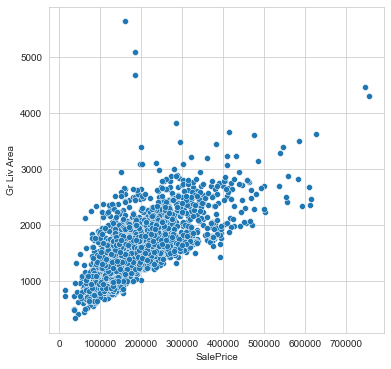

In [6]:
# check outliers Gr Liv Area > 4000
sns.scatterplot(x=df.SalePrice, y=df['Gr Liv Area']);

In [7]:
# check Sale Condition
df['Sale Condition'].value_counts()

Normal     2413
Partial     245
Abnorml     190
Family       46
Alloca       24
AdjLand      12
Name: Sale Condition, dtype: int64

In [8]:
# remove outliers
# see https://pandas.pydata.org/docs/user_guide/indexing.html?highlight=boolean%20indexing#boolean-indexing
outliers = df.index[(df['Gr Liv Area'] > 4000)]
df.drop(outliers, inplace=True)
df.shape

(2925, 82)

### Optimizing memory usage

Use `df.info()` to get a first view. In this case the dataset is not so
large (1.8 MB). If anything gets beyond hundreds of MBs in memory, it
helps to optimize, by using
[`pd.to_numeric(downcast=...)`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_numeric.html?highlight=to_numeric#pandas.to_numeric)
and converting categorical variables to
[`pd.categorical`](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html).
Doing so reduces the memory to 22% of the orginal (400 KB).

In [9]:
# objects to categorical
df[df.select_dtypes(include='object').columns] = df.select_dtypes(include='object').astype('category')

# convert integers to smallest unsigned integer and floats to smallest
for old, new in [('integer', 'unsigned'), ('float', 'float')]:
    for col in df.select_dtypes(include=old).columns:
        df[col] = pd.to_numeric(df[col], downcast=new)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2925 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Order            2925 non-null   uint16  
 1   PID              2925 non-null   uint32  
 2   MS SubClass      2925 non-null   uint8   
 3   MS Zoning        2925 non-null   category
 4   Lot Frontage     2435 non-null   float32 
 5   Lot Area         2925 non-null   uint32  
 6   Street           2925 non-null   category
 7   Alley            2925 non-null   category
 8   Lot Shape        2925 non-null   category
 9   Land Contour     2925 non-null   category
 10  Utilities        2925 non-null   category
 11  Lot Config       2925 non-null   category
 12  Land Slope       2925 non-null   category
 13  Neighborhood     2925 non-null   category
 14  Condition 1      2925 non-null   category
 15  Condition 2      2925 non-null   category
 16  Bldg Type        2925 non-null   category


In [10]:
# no data snooping
df_train, df_test = train_test_split(df, test_size=0.3)

In [11]:
# evaluate which columns have large percentage missing values, say 20%
cols_to_drop = (cols_with_nulls[cols_with_nulls / len(df) > 0.2] / len(df)).index
cols_with_nulls[cols_to_drop]

Series([], dtype: int64)

## Data preparation

So we are going to:

-   Create different regression models for the logarithm of the
    `SalePrice`
-   Drop columns with more than 20% missing values
-   Impute missing values using
    [`sklearn.impute.SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer)
    -   ‘median’ for numerical features
    -   fill with ‘missing’ for categorical features
-   use
    [`OneHotEncoding`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder)
    for all categorical variables
-   use
    [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
    on numerical variables just to be sure.

We are going to use
[`sklearn.pipeline.Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
for our whole workflow. It is good practice to structure your ML project
into separate pipelines for each model. This also allows for stacking
models, as is explained in [this example by Guillaume Lemaitre in the
sklearn
documentation](https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py).

### Selecting columns by [`dtype`](https://numpy.org/doc/stable/reference/arrays.scalars.html) with [`df.select_dtypes`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.select_dtypes.html?highlight=select_dtype)

In [12]:
# prepare X and y, using log(SalePrice) throughout
X = df_train[df_train.columns.difference(cols_to_drop).drop('SalePrice')]
y = np.log(df_train['SalePrice'])

# same for test set
X_test = df_test[df_test.columns.difference(cols_to_drop).drop('SalePrice')]
y_test = np.log(df_test['SalePrice'])

# read https://numpy.org/doc/stable/reference/arrays.scalars.html
# for understanding NumPy dtype hierarchy
cat_cols = X.select_dtypes(include='category').columns
num_cols = X.select_dtypes(include='number').columns

### Making a pipeline

If you want to read more about pipelines, see [this blogpost by Ankit
Goel](https://towardsdatascience.com/are-you-using-pipeline-in-scikit-learn-ac4cd85cb27f).

If you have used `category` dtypes from the start, you can access the
categories of each categorical column with
[`pd.Series.cat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.cat.html?highlight=cat#pandas.Series.cat).

In [13]:
# need to explicitly define categories for pipeline
for col in cat_cols:
    # need to add category for missings, otherwise error with OneHotEncoding
    X[col].cat.add_categories(MISSING, inplace=True)
categories = [X[col].cat.categories for col in cat_cols]

# combine all preprocessing for cat_cols in one pipeline
preprocess_cat_cols = make_pipeline(
    SimpleImputer(
        missing_values = np.nan,
        strategy='constant',
        fill_value=MISSING),
    OneHotEncoder(categories=categories)
)

# same for num_cols
preprocess_num_cols = make_pipeline(
    SimpleImputer(
        missing_values=np.nan,
        strategy='median'
        ),
    StandardScaler()
)

# compose dataset with make_column_transformer
prepare_linear = make_column_transformer(
    (preprocess_num_cols, num_cols),
    (preprocess_cat_cols, cat_cols),
    remainder='drop'
)

## Linear models

### [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

In [54]:
ols = make_pipeline(
    prepare_linear,
    LinearRegression()
    )

ols_scores = cross_validate(
    ols, X, y,
    cv=10,
    scoring=['neg_mean_squared_error'],
    return_train_score=True,
    return_estimator=True,
)

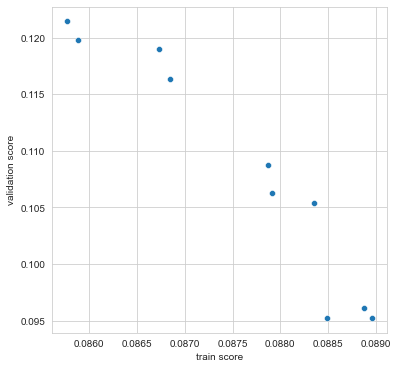

In [55]:
def plot_cv_scores(cv_score):
    """
    Make scatterplot from cross_validate.score object.
    """
    ax = sns.scatterplot(
        x=np.sqrt(-cv_score['train_neg_mean_squared_error']),
        y=np.sqrt(-cv_score['test_neg_mean_squared_error']),
    )
    ax.set(
        xlabel='train score',
        ylabel='validation score',
    )
    return ax


plot_cv_scores(ols_scores);

We can conclude from this that we need more work: a low RMSLE on the
training set results in the highest RMSLE for the validation set (and
vice versa). This means we are overfitting. The best model for now is in
the bottom right corner, with the RMSLE around 0.08. Let’s check which
estimator that is and do final scoring on test set.

In [56]:
def get_best_model(cv_scores):
    """
    Return best (most conservative) model from cross_validate object.
    
    Uses np.argmax to find bottomright point == largest RMLSE
    """
    index = np.argmax(np.sqrt(-cv_scores['train_neg_mean_squared_error']))
    model = cv_scores['estimator'][index]
    rmsle = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    return (model, rmsle)

ols_best_model, ols_rmsle = get_best_model(ols_scores)
print(f"Best OLS model:\n  RMLSE test: {ols_rmsle:0.5f}")

Best OLS model:
  RMLSE test: 0.13798

Not bad: a simple regression model, with preparing the data just as the
author instructed yields a RMSLE of around 0.13. Let’s see where that
gets us on the leaderboard.

In [17]:
leaderboard = pd.read_csv(LEADERBOARD).sort_values('Score').reset_index()
leaderboard.Score.searchsorted(ols_rmsle)

2331

Not bad: given there are more than 5,000 entries we are already in the
30%-percentile.

### More detailed look at linear model

The author of the dataset states that it is easiest to build an
estimator only for houses with `Sale Condition == 'Normal'`. Let’s check
what the distribution of house prices is per `Sale Condition`.

In [18]:
df_original = pd.read_csv(URL)
df_original['Sale Condition'].value_counts()

Normal     2413
Partial     245
Abnorml     190
Family       46
Alloca       24
AdjLand      12
Name: Sale Condition, dtype: int64

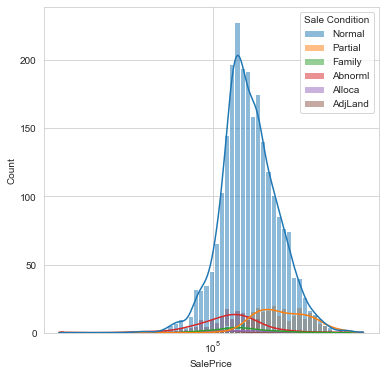

In [19]:
sns.histplot(df_original, x='SalePrice', hue='Sale Condition', kde=True, log_scale=True, common_norm=True);

From this we conclude that the distribution of the `log(Sale Price)` is
quite different depending on `Sale Condition`. This probably explains
why our performance with a simple machine learning model does so well
compared to the leaderboard. In another notebook we will build separate
linear models for each `Sale Condition` and see how that performs.

#### Exercise

Make change in section 2.1 in this notebook and re-run it to see the
performance of the linear model only for `Sale Condition == "Normal"`.
Hint: adjust the boolean index

#### Answer

RMSLE should be around 0.10, which sets the model around 130th place
i.e. in the top 2.5% (although this is cheating of course).

### [`sklearn.linear_model.LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html?highlight=lasso#sklearn.linear_model.LassoCV)

We use `LassoCV` so we can do cross-validation directly.

In [20]:
lasso = make_pipeline(
    prepare_linear,
    LassoCV(cv=10)
).fit(X, y)
lasso

Pipeline Pipeline(steps=[('columntransformer',
 ColumnTransformer(transformers=[('pipeline-1',
 Pipeline(steps=[('simpleimputer',
 SimpleImputer(strategy='median')),
 ('standardscaler',
 StandardScaler())]),
 Index(['1st Flr SF', '2nd Flr SF', '3Ssn Porch', 'Bedroom AbvGr',
 'Bsmt Full Bath', 'Bsmt Half Bath', 'Bsmt Unf SF', 'BsmtFin SF 1',
 'BsmtFin SF 2', 'Enclosed Porch', 'Fireplaces', 'Full Bath...
 'Exterior 2nd', 'Fence', 'Fireplace Qu', 'Foundation', 'Functional',
 'Garage Cond', 'Garage Finish', 'Garage Qual', 'Garage Type', 'Heating',
 'Heating QC', 'House Style', 'Kitchen Qual', 'Land Contour',
 'Land Slope', 'Lot Config', 'Lot Shape', 'MS Zoning', 'Mas Vnr Type',
 'Misc Feature', 'Neighborhood', 'Paved Drive', 'Pool QC', 'Roof Matl',
 'Roof Style', 'Sale Condition', 'Sale Type', 'Street', 'Utilities'],
 dtype='object'))])),
 ('lassocv', LassoCV(cv=10))]) columntransformer: ColumnTransformer ColumnTransformer(transformers=[('pipeline-1',
 Pipeline(steps=[('simpleimputer',
 SimpleImputer(strategy='median')),
 ('standardscaler',
 StandardScaler())]),
 Index(['1st Flr SF', '2nd Flr SF', '3Ssn Porch', 'Bedroom AbvGr',
 'Bsmt Full Bath', 'Bsmt Half Bath', 'Bsmt Unf SF', 'BsmtFin SF 1',
 'BsmtFin SF 2', 'Enclosed Porch', 'Fireplaces', 'Full Bath',
 'Garage Area', 'Garage Cars', 'Garage Yr...
 'Exterior 2nd', 'Fence', 'Fireplace Qu', 'Foundation', 'Functional',
 'Garage Cond', 'Garage Finish', 'Garage Qual', 'Garage Type', 'Heating',
 'Heating QC', 'House Style', 'Kitchen Qual', 'Land Contour',
 'Land Slope', 'Lot Config', 'Lot Shape', 'MS Zoning', 'Mas Vnr Type',
 'Misc Feature', 'Neighborhood', 'Paved Drive', 'Pool QC', 'Roof Matl',
 'Roof Style', 'Sale Condition', 'Sale Type', 'Street', 'Utilities'],
 dtype='object'))]) pipeline-1 Index(['1st Flr SF', '2nd Flr SF', '3Ssn Porch', 'Bedroom AbvGr',
 'Bsmt Full Bath', 'Bsmt Half Bath', 'Bsmt Unf SF', 'BsmtFin SF 1',
 'BsmtFin SF 2', 'Enclosed Porch', 'Fireplaces', 'Full Bath',
 'Garage Area', 'Garage Cars', 'Garage Yr Blt', 'Gr Liv Area',
 'Half Bath', 'Kitchen AbvGr', 'Lot Area', 'Lot Frontage',
 'Low Qual Fin SF', 'MS SubClass', 'Mas Vnr Area', 'Misc Val', 'Mo Sold',
 'Open Porch SF', 'Order', 'Overall Cond', 'Overall Qual', 'PID',
 'Pool Area', 'Screen Porch', 'TotRms AbvGrd', 'Total Bsmt SF',
 'Wood Deck SF', 'Year Built', 'Year Remod/Add', 'Yr Sold'],
 dtype='object') SimpleImputer SimpleImputer(strategy='median') StandardScaler StandardScaler() pipeline-2 Index(['Alley', 'Bldg Type', 'Bsmt Cond', 'Bsmt Exposure', 'Bsmt Qual',
 'BsmtFin Type 1', 'BsmtFin Type 2', 'Central Air', 'Condition 1',
 'Condition 2', 'Electrical', 'Exter Cond', 'Exter Qual', 'Exterior 1st',
 'Exterior 2nd', 'Fence', 'Fireplace Qu', 'Foundation', 'Functional',
 'Garage Cond', 'Garage Finish', 'Garage Qual', 'Garage Type', 'Heating',
 'Heating QC', 'House Style', 'Kitchen Qual', 'Land Contour',
 'Land Slope', 'Lot Config', 'Lot Shape', 'MS Zoning', 'Mas Vnr Type',
 'Misc Feature', 'Neighborhood', 'Paved Drive', 'Pool QC', 'Roof Matl',
 'Roof Style', 'Sale Condition', 'Sale Type', 'Street', 'Utilities'],
 dtype='object') SimpleImputer SimpleImputer(fill_value='missing', strategy='constant') OneHotEncoder OneHotEncoder(categories=[Index(['Grvl', 'Pave', 'not present', 'missing'], dtype='object'),
 Index(['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE', 'missing'], dtype='object'),
 Index(['Ex', 'Fa', 'Gd', 'Po', 'TA', 'not present', 'missing'], dtype='object'),
 Index(['Av', 'Gd', 'Mn', 'No', 'missing'], dtype='object'),
 Index(['Ex', 'Fa', 'Gd', 'Po', 'TA', 'not present', 'missing'], dtype...
 Index(['1.5Fin', '1.5Unf', '1Story', '2.5Fin', '2.5Unf', '2Story', 'SFoyer',
 'SLvl', 'missing'],
 dtype='object'),
 Index(['Ex', 'Fa', 'Gd', 'Po', 'TA', 'missing'], dtype='object'),
 Index(['Bnk', 'HLS', 'Low', 'Lvl', 'missing'], dtype='object'),
 Index(['Gtl', 'Mod', 'Sev', 'missing'], dtype='object'),
 Index(['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside', 'missing'], dtype='object'), ...]) LassoCV LassoCV(cv=1

In [21]:
# get column names of OneHotEncoded categorical columns
# see https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer
onehot_features = lasso['columntransformer'].named_transformers_['pipeline-2'].named_steps['onehotencoder'].get_feature_names(cat_cols)

In [22]:
lasso_coef_ = (pd.DataFrame(
    {'feature': np.concatenate([num_cols.values, onehot_features]),
     'coef_': lasso['lassocv'].coef_,
     'coef_abs': np.abs(lasso['lassocv'].coef_)})
    .sort_values('coef_abs', ascending=False)
)
lasso_coef_.head(25)

In [23]:
# all variables that are put to zero
lasso_coef_.loc[lasso_coef_.coef_ == 0, 'feature']

296      Neighborhood_NAmes
283     Neighborhood_BrDale
274    Mas Vnr Type_missing
275       Misc Feature_Gar2
276       Misc Feature_Othr
               ...         
205      Garage Type_2Types
98         Condition 2_Norm
207     Garage Type_Basment
208     Garage Type_BuiltIn
359       Utilities_missing
Name: feature, Length: 230, dtype: object

Out-of-the-box, `LassoCV` sets 225 (one-hot encoded) features to
coefficient zero. As an intermediate conclusion, let’s check the RMSLE
for the train and test set.

In [24]:
lasso_best_rmsle = np.sqrt(mean_squared_error(y_test, lasso.predict(X_test)))
print(f"""Lasso RMSLE:
  train: {np.sqrt(mean_squared_error(y, lasso.predict(X))):.5f}
   test: {lasso_best_rmsle}
  alpha: {lasso['lassocv'].alpha_:.6f}
  rank on leaderboard: {leaderboard.Score.searchsorted(lasso_best_rmsle)} 
""")

Lasso RMSLE:
  train: 0.09555
   test: 0.13593791911157707
  alpha: 0.000325
  rank on leaderboard: 2157 


### FAQ: does it matter whether Y is normally distributed?

The instructions fromt the Kaggle competition states

> The performance metric for your prediction model is the
> Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted
> value and the logarithm of the observed sales price. (Taking logs
> means that errors in predicting expensive houses and cheap houses will
> affect the result equally.)

So what would in fact happen if we just predicted `SalePrice` without
taking the log? A linear model would perform a lot worse. Recall that a
linear model will fit a function

$$ y = \alpha + \beta X_i + \epsilon_i $$

If the spread in $y$ is unbalanced, as is the case here with a lot of
observations on the left-hand side, and a long-tail on the right-hand
side, the coefficients $beta_n$ will never be able to accurately model
both sides of the distribution of $y$. This is remedied by taking the
log and fitting a function

$$ log(y) = \alpha + \beta X_i + \epsilon_i $$

You can think of a log-normal distribution as a ‘multiplicative normal
distribution’: each 1-unit increase in $X$ multiplies the expected value
of $y$ by $e^β$.

#### Further reading

-   article on [Linear Regression MOdels with Logarithmic
    Transformations](https://github.com/jads-nl/discover-projects/blob/main/ames-housing/benoit2011logmodels.pdf)
    from Kenneth Benoit (LSE)
-   article on [Log-normal distributions across the
    sciences](https://github.com/jads-nl/discover-projects/blob/main/ames-housing/limpert2001log-normal.pdf)
    by Limpert et al. (2001)

### Adding [`KBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) feature selection

Let’s see how the RMSLE decreases as we add more features.

In [25]:
# warnings can be ignored, see
# https://github.com/scikit-learn/scikit-learn/issues/11395
from sklearn.feature_selection import SelectKBest, f_regression

lassos = {}
for k in range(10, 130, 10):
    lassos[k] = make_pipeline(
        prepare_linear,
        SelectKBest(
            f_regression,
            k=k),
        LassoCV(cv=10)
        ).fit(X,y)

/Users/dkapitan/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/dkapitan/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/dkapitan/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/dkapitan/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/dkapitan/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/dkapitan/.local/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_s

In [26]:
kbest_rmsle_train = [np.sqrt(mean_squared_error(y, lasso.predict(X))) for lasso in lassos.values()]
kbest_rmsle_test = [np.sqrt(mean_squared_error(y_test, lasso.predict(X_test))) for lasso in lassos.values()]

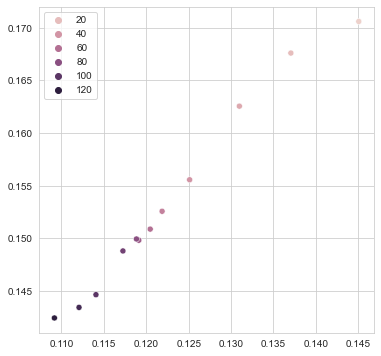

In [27]:
sns.scatterplot(x=kbest_rmsle_train, y=kbest_rmsle_test, hue=lassos.keys());

So clearly the model improves as we add more KBest features. Let’s leave
this for now and move on.

## Non-linear models

### Random Forest

In [28]:
preprocess_cat_cols_2 = make_pipeline(
    SimpleImputer(
        missing_values = np.nan,
        strategy='constant',
        fill_value=MISSING),
    OrdinalEncoder(categories=categories)
)

preprocess_num_cols_2 = make_pipeline(
    SimpleImputer(
        missing_values=np.nan,
        strategy='median'
        ),
    StandardScaler(),
)

prepare_nonlinear = make_column_transformer(
    (preprocess_num_cols_2, num_cols),
    (preprocess_cat_cols_2, cat_cols),
    remainder='drop'
)

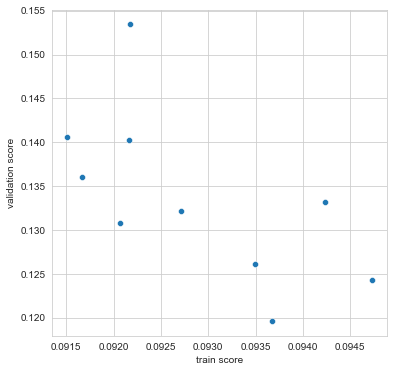

In [29]:
rf = make_pipeline(
    prepare_nonlinear,
    RandomForestRegressor(n_jobs=-1,
                          random_state=42,
                          min_weight_fraction_leaf=0.005)
)

rf_score = cross_validate(
    rf, X, y,
    scoring=['neg_mean_squared_error'],
    cv=10,
    return_train_score=True,
)

plot_cv_scores(rf_score);

Clearly we are overfitting the random forest, getting RMSLE of 0.09 for
the training score vs a RMSLE between (0.11, 0.135) for the validation
score. To do this properly, we need to perform hyperparameter-tuning
with `GridSearchCV`. But rather than doing that with random forest, we
will do that with my personal favourite XGBboost, as it allows for more
regularization.

### XGBoost

In [30]:
xgb = Pipeline(steps=[
    ('pre', prepare_nonlinear),
    ('xgb', XGBRegressor())
])

xgb_params = {
    'xgb__n_estimators': [100], # only do small number for grid search to reduce compute
    'xgb__objective': ['reg:squarederror'],
    'xgb__eval_metric': ['rmse'],
    'xgb__learning_rate': [.05, .1, .15],
    'xgb__max_depth': [3, 4, 5],
    'xgb__min_child_weight': [2, 3, 4],
    'xgb__gamma': [0.1, 0.2, ],
    'xgb__reg_alpha': [0.1, 0.5],
    'xgb__reg_lambda': [0.1, 0.5],
    'xgb__colsample_bytree': [0.3],
        }

search = GridSearchCV(xgb, xgb_params, scoring='neg_mean_squared_error', n_jobs=-1)

In [31]:
%%time
search.fit(X, y)

CPU times: user 20.4 s, sys: 637 ms, total: 21 s
Wall time: 4min 40s

GridSearchCV GridSearchCV(estimator=Pipeline(steps=[('pre',
 ColumnTransformer(transformers=[('pipeline-1',
 Pipeline(steps=[('simpleimputer',
 SimpleImputer(strategy='median')),
 ('standardscaler',
 StandardScaler())]),
 Index(['1st Flr SF', '2nd Flr SF', '3Ssn Porch', 'Bedroom AbvGr',
 'Bsmt Full Bath', 'Bsmt Half Bath', 'Bsmt Unf SF', 'BsmtFin SF 1',
 'BsmtFin SF 2', 'Enclosed Porch', 'Fireplaces',...
 n_jobs=-1,
 param_grid={'xgb__colsample_bytree': [0.3],
 'xgb__eval_metric': ['rmse'], 'xgb__gamma': [0.1, 0.2],
 'xgb__learning_rate': [0.05, 0.1, 0.15],
 'xgb__max_depth': [3, 4, 5],
 'xgb__min_child_weight': [2, 3, 4],
 'xgb__n_estimators': [100],
 'xgb__objective': ['reg:squarederror'],
 'xgb__reg_alpha': [0.1, 0.5],
 'xgb__reg_lambda': [0.1, 0.5]},
 scoring='neg_mean_squared_error') pre: ColumnTransformer ColumnTransformer(transformers=[('pipeline-1',
 Pipeline(steps=[('simpleimputer',
 SimpleImputer(strategy='median')),
 ('standardscaler',
 StandardScaler())]),
 Index(['1st Flr SF', '2nd Flr SF', '3Ssn Porch', 'Bedroom AbvGr',
 'Bsmt Full Bath', 'Bsmt Half Bath', 'Bsmt Unf SF', 'BsmtFin SF 1',
 'BsmtFin SF 2', 'Enclosed Porch', 'Fireplaces', 'Full Bath',
 'Garage Area', 'Garage Cars', 'Garage Yr...
 'Exterior 2nd', 'Fence', 'Fireplace Qu', 'Foundation', 'Functional',
 'Garage Cond', 'Garage Finish', 'Garage Qual', 'Garage Type', 'Heating',
 'Heating QC', 'House Style', 'Kitchen Qual', 'Land Contour',
 'Land Slope', 'Lot Config', 'Lot Shape', 'MS Zoning', 'Mas Vnr Type',
 'Misc Feature', 'Neighborhood', 'Paved Drive', 'Pool QC', 'Roof Matl',
 'Roof Style', 'Sale Condition', 'Sale Type', 'Street', 'Utilities'],
 dtype='object'))]) pipeline-1 Index(['1st Flr SF', '2nd Flr SF', '3Ssn Porch', 'Bedroom AbvGr',
 'Bsmt Full Bath', 'Bsmt Half Bath', 'Bsmt Unf SF', 'BsmtFin SF 1',
 'BsmtFin SF 2', 'Enclosed Porch', 'Fireplaces', 'Full Bath',
 'Garage Area', 'Garage Cars', 'Garage Yr Blt', 'Gr Liv Area',
 'Half Bath', 'Kitchen AbvGr', 'Lot Area', 'Lot Frontage',
 'Low Qual Fin SF', 'MS SubClass', 'Mas Vnr Area', 'Misc Val', 'Mo Sold',
 'Open Porch SF', 'Order', 'Overall Cond', 'Overall Qual', 'PID',
 'Pool Area', 'Screen Porch', 'TotRms AbvGrd', 'Total Bsmt SF',
 'Wood Deck SF', 'Year Built', 'Year Remod/Add', 'Yr Sold'],
 dtype='object') SimpleImputer SimpleImputer(strategy='median') StandardScaler StandardScaler() pipeline-2 Index(['Alley', 'Bldg Type', 'Bsmt Cond', 'Bsmt Exposure', 'Bsmt Qual',
 'BsmtFin Type 1', 'BsmtFin Type 2', 'Central Air', 'Condition 1',
 'Condition 2', 'Electrical', 'Exter Cond', 'Exter Qual', 'Exterior 1st',
 'Exterior 2nd', 'Fence', 'Fireplace Qu', 'Foundation', 'Functional',
 'Garage Cond', 'Garage Finish', 'Garage Qual', 'Garage Type', 'Heating',
 'Heating QC', 'House Style', 'Kitchen Qual', 'Land Contour',
 'Land Slope', 'Lot Config', 'Lot Shape', 'MS Zoning', 'Mas Vnr Type',
 'Misc Feature', 'Neighborhood', 'Paved Drive', 'Pool QC', 'Roof Matl',
 'Roof Style', 'Sale Condition', 'Sale Type', 'Street', 'Utilities'],
 dtype='object') SimpleImputer SimpleImputer(fill_value='missing', strategy='constant') OrdinalEncoder OrdinalEncoder(categories=[Index(['Grvl', 'Pave', 'not present', 'missing'], dtype='object'),
 Index(['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE', 'missing'], dtype='object'),
 Index(['Ex', 'Fa', 'Gd', 'Po', 'TA', 'not present', 'missing'], dtype='object'),
 Index(['Av', 'Gd', 'Mn', 'No', 'missing'], dtype='object'),
 Index(['Ex', 'Fa', 'Gd', 'Po', 'TA', 'not present', 'missing'], dtyp...
 Index(['1.5Fin', '1.5Unf', '1Story', '2.5Fin', '2.5Unf', '2Story', 'SFoyer',
 'SLvl', 'missing'],
 dtype='object'),
 Index(['Ex', 'Fa', 'Gd', 'Po', 'TA', 'missing'], dtype='object'),
 Index(['Bnk', 'HLS', 'Low', 'Lvl', 'missing'], dtype='object'),
 Index(['Gtl', 'Mod', 'Sev', 'missing'], dtype='object'),
 Index(['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside', 'missing'], dtype='object'), ...]) XGBRegressor XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
 colsample_bynode=None, colsam

In [32]:
# get best parameters and train full XGBoost with larger number of estimators
xgb_best_params = {k.split('__')[-1]: v for k,v in search.best_params_.items() if k != 'xgb__n_estimators'}
xgb_best = Pipeline(steps=[
    ('pre', prepare_nonlinear),
    ('xgb', XGBRegressor(n_estimators=1000, **xgb_best_params))
])
xgb_best_params

{'colsample_bytree': 0.3,
 'eval_metric': 'rmse',
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 2,
 'objective': 'reg:squarederror',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1}

In [33]:
%%time
xgb_cv = cross_validate(
    xgb_best, X, y,
    scoring=['neg_mean_squared_error'],
    cv=10,
    return_train_score=True,
    return_estimator=True,
)

CPU times: user 1min 44s, sys: 928 ms, total: 1min 45s
Wall time: 15.2 s

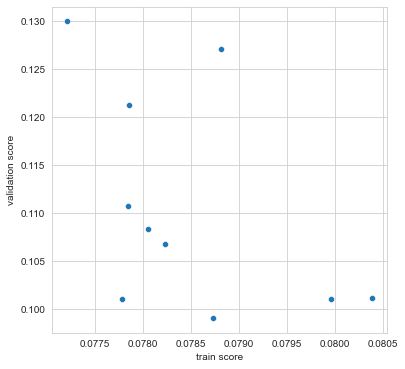

In [35]:
plot_cv_scores(xgb_cv);

In [36]:
xgb_best_model, xgb_rmsle = get_best_model(xgb_cv)
print(f"Best XGBoost model:\n  RMLSE: {xgb_rmsle:0.5f}")

Best XGBoost model:
  RMLSE: 0.14401

So XGBoost actually doesn’t do better than Lasso, which is surprising.
Yet, this result is also confirmed by [Bashkeel’s solution to Ames
Housing](https://github.com/Bashkeel/House-Prices). As a final exercise,
we are going to use PCA on the numerical columns and revisit linear
models to demonstrate a more elaborate pipeline.

## Linear models revisted

### PCA and linear model

We are going to add PCA to our Lasso pipeline, following [sklearn’s
documentation](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html).

In [37]:
preprocess_num_cols_3 = make_pipeline(
    SimpleImputer(
        missing_values=np.nan,
        strategy='median'
        ),
    StandardScaler(),
    PCA(),
)

prepare_pca_lasso = ColumnTransformer(
    [('num', preprocess_num_cols_3, num_cols),
     ('cat', preprocess_cat_cols, cat_cols)],
    remainder='drop'
)

pca_lasso = Pipeline(steps=[
    ('prep', prepare_pca_lasso),
    ('lasso', Lasso())
])

pca_lasso_params = {
    'prep__num__pca__n_components': [8, 12, 16, 20],
    'lasso__alpha': [.0001, .0002, .0005, .001, .002, .005 ],
    'lasso__selection': ['random']}
search_pca_lasso = GridSearchCV(pca_lasso, pca_lasso_params, scoring='neg_mean_squared_error', n_jobs=-1)

In [38]:
search_pca_lasso.fit(X, y)

GridSearchCV GridSearchCV(estimator=Pipeline(steps=[('prep',
 ColumnTransformer(transformers=[('num',
 Pipeline(steps=[('simpleimputer',
 SimpleImputer(strategy='median')),
 ('standardscaler',
 StandardScaler()),
 ('pca',
 PCA())]),
 Index(['1st Flr SF', '2nd Flr SF', '3Ssn Porch', 'Bedroom AbvGr',
 'Bsmt Full Bath', 'Bsmt Half Bath', 'Bsmt Unf SF', 'BsmtFin SF 1',
 'BsmtFin SF 2', 'Enclosed Porch', 'Fire...
 'Land Slope', 'Lot Config', 'Lot Shape', 'MS Zoning', 'Mas Vnr Type',
 'Misc Feature', 'Neighborhood', 'Paved Drive', 'Pool QC', 'Roof Matl',
 'Roof Style', 'Sale Condition', 'Sale Type', 'Street', 'Utilities'],
 dtype='object'))])),
 ('lasso', Lasso())]),
 n_jobs=-1,
 param_grid={'lasso__alpha': [0.0001, 0.0002, 0.0005, 0.001, 0.002,
 0.005],
 'lasso__selection': ['random'],
 'prep__num__pca__n_components': [8, 12, 16, 20]},
 scoring='neg_mean_squared_error') prep: ColumnTransformer ColumnTransformer(transformers=[('num',
 Pipeline(steps=[('simpleimputer',
 SimpleImputer(strategy='median')),
 ('standardscaler',
 StandardScaler()),
 ('pca', PCA())]),
 Index(['1st Flr SF', '2nd Flr SF', '3Ssn Porch', 'Bedroom AbvGr',
 'Bsmt Full Bath', 'Bsmt Half Bath', 'Bsmt Unf SF', 'BsmtFin SF 1',
 'BsmtFin SF 2', 'Enclosed Porch', 'Fireplaces', 'Full Bath',
 'Garage Area', 'Garage Cars', 'G...
 'Exterior 2nd', 'Fence', 'Fireplace Qu', 'Foundation', 'Functional',
 'Garage Cond', 'Garage Finish', 'Garage Qual', 'Garage Type', 'Heating',
 'Heating QC', 'House Style', 'Kitchen Qual', 'Land Contour',
 'Land Slope', 'Lot Config', 'Lot Shape', 'MS Zoning', 'Mas Vnr Type',
 'Misc Feature', 'Neighborhood', 'Paved Drive', 'Pool QC', 'Roof Matl',
 'Roof Style', 'Sale Condition', 'Sale Type', 'Street', 'Utilities'],
 dtype='object'))]) num Index(['1st Flr SF', '2nd Flr SF', '3Ssn Porch', 'Bedroom AbvGr',
 'Bsmt Full Bath', 'Bsmt Half Bath', 'Bsmt Unf SF', 'BsmtFin SF 1',
 'BsmtFin SF 2', 'Enclosed Porch', 'Fireplaces', 'Full Bath',
 'Garage Area', 'Garage Cars', 'Garage Yr Blt', 'Gr Liv Area',
 'Half Bath', 'Kitchen AbvGr', 'Lot Area', 'Lot Frontage',
 'Low Qual Fin SF', 'MS SubClass', 'Mas Vnr Area', 'Misc Val', 'Mo Sold',
 'Open Porch SF', 'Order', 'Overall Cond', 'Overall Qual', 'PID',
 'Pool Area', 'Screen Porch', 'TotRms AbvGrd', 'Total Bsmt SF',
 'Wood Deck SF', 'Year Built', 'Year Remod/Add', 'Yr Sold'],
 dtype='object') SimpleImputer SimpleImputer(strategy='median') StandardScaler StandardScaler() PCA PCA() cat Index(['Alley', 'Bldg Type', 'Bsmt Cond', 'Bsmt Exposure', 'Bsmt Qual',
 'BsmtFin Type 1', 'BsmtFin Type 2', 'Central Air', 'Condition 1',
 'Condition 2', 'Electrical', 'Exter Cond', 'Exter Qual', 'Exterior 1st',
 'Exterior 2nd', 'Fence', 'Fireplace Qu', 'Foundation', 'Functional',
 'Garage Cond', 'Garage Finish', 'Garage Qual', 'Garage Type', 'Heating',
 'Heating QC', 'House Style', 'Kitchen Qual', 'Land Contour',
 'Land Slope', 'Lot Config', 'Lot Shape', 'MS Zoning', 'Mas Vnr Type',
 'Misc Feature', 'Neighborhood', 'Paved Drive', 'Pool QC', 'Roof Matl',
 'Roof Style', 'Sale Condition', 'Sale Type', 'Street', 'Utilities'],
 dtype='object') SimpleImputer SimpleImputer(fill_value='missing', strategy='constant') OneHotEncoder OneHotEncoder(categories=[Index(['Grvl', 'Pave', 'not present', 'missing'], dtype='object'),
 Index(['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE', 'missing'], dtype='object'),
 Index(['Ex', 'Fa', 'Gd', 'Po', 'TA', 'not present', 'missing'], dtype='object'),
 Index(['Av', 'Gd', 'Mn', 'No', 'missing'], dtype='object'),
 Index(['Ex', 'Fa', 'Gd', 'Po', 'TA', 'not present', 'missing'], dtype...
 Index(['1.5Fin', '1.5Unf', '1Story', '2.5Fin', '2.5Unf', '2Story', 'SFoyer',
 'SLvl', 'missing'],
 dtype='object'),
 Index(['Ex', 'Fa', 'Gd', 'Po', 'TA', 'missing'], dtype='object'),
 Index(['Bnk', 'HLS', 'Low', 'Lvl', 'missing'], dtype='object'),
 Index(['Gtl', 'Mod', 'Sev', 'missing'], dtype='object'),
 Index(['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside', 'missing'], dtype='object'), ...]) Lasso Lasso()

In [39]:
search_pca_lasso.best_params_

{'lasso__alpha': 0.0002,
 'lasso__selection': 'random',
 'prep__num__pca__n_components': 20}

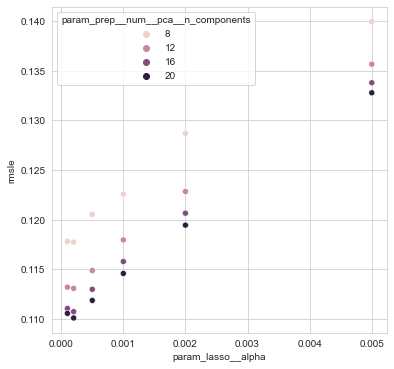

In [40]:
cv_results = pd.DataFrame(search_pca_lasso.cv_results_)
cv_results['rmsle'] = np.sqrt(-cv_results.mean_test_score)
sns.scatterplot(data=cv_results, x='param_lasso__alpha', y='rmsle', hue='param_prep__num__pca__n_components');

In [41]:
pca_lasso_rmsle = np.sqrt(-search_pca_lasso.best_score_)
print(f"""
Results PCA - Lasso:
  RMSLE: {pca_lasso_rmsle}
  Leaderboard {leaderboard.Score.searchsorted(pca_lasso_rmsle)}
  Test score: {np.sqrt(mean_squared_error(y_test, search_pca_lasso.best_estimator_.predict(X_test)))}
""")


Results PCA - Lasso:
  RMSLE: 0.11010899737867327
  Leaderboard 133
  Test score: 0.14375396943292268


In [42]:
# table with num_cols and component coefficients
pca_ = search_pca_lasso.best_estimator_['prep'].named_transformers_['num']['pca']
pd.DataFrame(pca_.components_).transpose().set_index(num_cols).round(3)

In [43]:
# taken from https://stackoverflow.com/a/46766116/3197404
def biplot(score,coeff,labels=None,plot_pc=(0,1)):
    xs = score[:,plot_pc[0]]
    ys = score[:,plot_pc[1]]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'y',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-.5,.5)
    plt.ylim(-.5,.5)
    plt.xlabel("PC{}".format(plot_pc[0]+1))
    plt.ylabel("PC{}".format(plot_pc[1]+1))
    plt.grid()

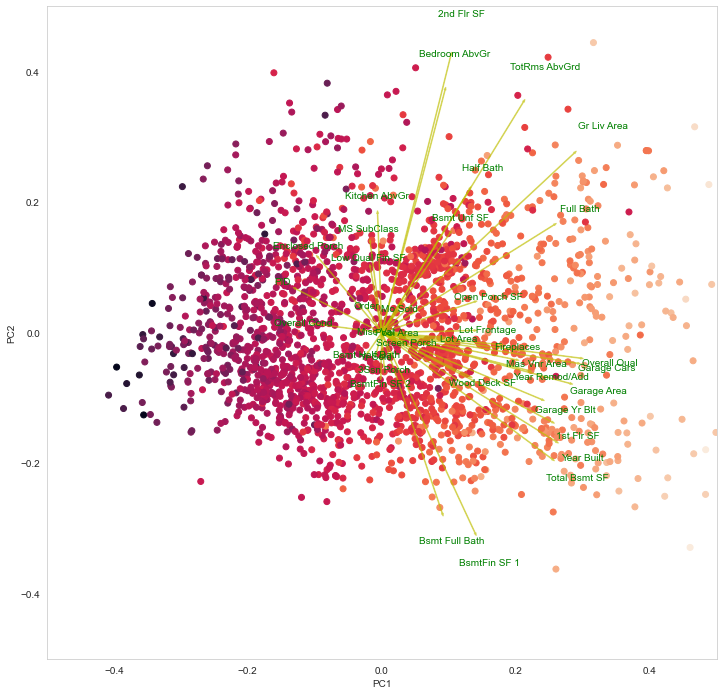

In [44]:
x_pca = preprocess_num_cols_3.fit_transform(X[num_cols])
plt.figure(figsize=(12,12))
biplot(x_pca[:,:],np.transpose(pca_.components_[0:2, :]), labels=num_cols, plot_pc=(0,1))

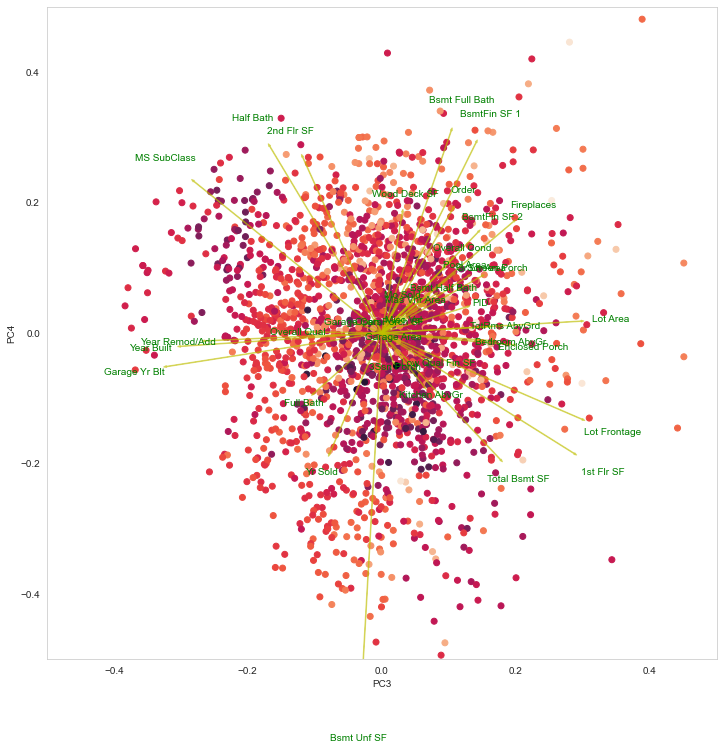

In [45]:
plt.figure(figsize=(12,12))
biplot(x_pca[:,:],np.transpose(pca_.components_[2:4, :]), labels=num_cols, plot_pc=(2,3))

### Does it help to use separate linear models?

Going back to `Sale Condition`, we are going to build 3 separate linear
models and see whether that gives a better result. Curious to see what
happens.

In [46]:
sale_condition_other = ['AdjLand', 'Alloca', 'Family', 'missing']
df.groupby('Sale Condition')['SalePrice'].describe().round(2)

In [47]:
from functools import partial

ols_cv = partial(cross_validate,
    cv=10,
    scoring=['neg_mean_squared_error'],
    return_train_score=True,
    return_estimator=True
)
ols_models = {'Normal': {}, 'Partial': {}, 'Abnorml': {}, 'Other': {}}

for condition in ols_models.keys():
    if condition != 'Other':
        mask = X['Sale Condition']==condition
    else:
        mask = X['Sale Condition'].isin(sale_condition_other)    
    ols_ = make_pipeline(
        prepare_linear,
        LinearRegression()
    )
    ols_models[condition]['cv'] = ols_cv(ols_, X.loc[mask, :], y[mask])
    ols_best_index_ = np.argmax(np.sqrt(-ols_models[condition]['cv']['train_neg_mean_squared_error']))
    ols_models[condition]['estimator'] = ols_models[condition]['cv']['estimator'][ols_best_index_]

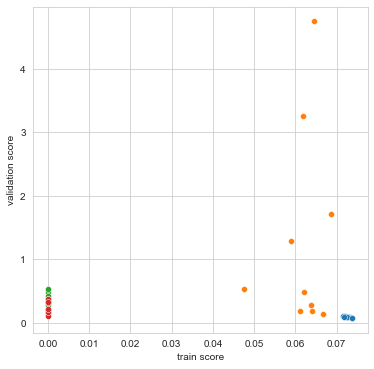

In [48]:
for condition, ols_score in ols_models.items():
    plot_cv_scores(ols_models[condition]['cv']);

In [49]:
ols_rmsle = {}
for condition in ols_models.keys():
    if condition != 'Other':
        mask = X_test['Sale Condition']==condition
    else:
        mask = X_test['Sale Condition'].isin(['AdjLand', 'Alloca', 'Familiy', 'missing'])   
    ols_rmsle[condition] = np.sqrt(
        mean_squared_error(y_test[mask],
        ols_models[condition]['estimator'].predict(X_test.loc[mask, :])))
ols_rmsle

{'Normal': 0.09895196401501209,
 'Partial': 1.787612343242684,
 'Abnorml': 0.4426869916346495,
 'Other': 0.257988869076319}

In [50]:
# calculate weighted sum of squares of separate models
condition_counts = X_test.groupby('Sale Condition')['Sale Condition'].count()
other_count = X_test[X_test['Sale Condition'].isin(sale_condition_other)].count()[0]


total_ols_rmsle = np.sqrt(sum([v**2 * condition_counts[k] if k != 'Other'
 else v**2 * other_count
 for k,v in ols_rmsle.items()])/condition_counts.sum())
total_ols_rmsle

0.5421656464440533

So this isn’t really useful

In [51]:
# checking calculation weighted sum of squares
ols_msle = {k:v**2 for k,v in ols_rmsle.items()}
ols_msle

{'Normal': 0.009791491182428247,
 'Partial': 3.1955578897135997,
 'Abnorml': 0.1959717725625362,
 'Other': 0.06655825656727807}

In [52]:
np.sqrt(sum({k:(v**2 * condition_counts[k] if k != 'Other'
 else v**2 * other_count)
 for k,v in ols_rmsle.items()}.values())/condition_counts.sum())

0.5421656464440533

## Concluding remarks

Hopefully this notebook has given you some clear pointers how to
structure your sklearn pipelines. The models we have developed performed
ok, with the validation scores somewhere between the 25% and 50%
percentile.

However, all test scores were significantly worse than validation
scores. This indicates we still haven’t tackled the overfitting and/or
randomness of local solutions in the model properly. It is left as an
exercise to further optimize you model to ensure your solutions are
stable and generalizable.